a_r = 1.0  b_r = 1.2
Epoch 0 | D: 9.3521 | G: 0.2065
Epoch 400 | D: 2.0851 | G: -2.1079
Epoch 800 | D: 4.2272 | G: -3.9000
Epoch 1200 | D: 6.4080 | G: -4.8880
Epoch 1600 | D: 8.5301 | G: -4.8158


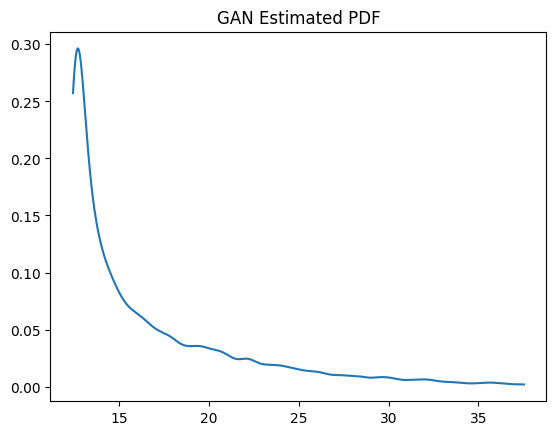

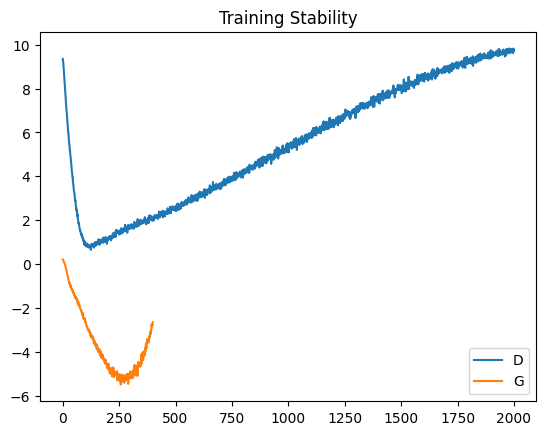

Mode Coverage Score: 8.715812226541392e-05


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


ROLL = 102313038

def compute_params(r):
    a_r = 0.5 * (r % 7)
    b_r = 0.3 * ((r % 5) + 1)
    return a_r, b_r

def transform_x_to_z(x, r):
    a_r, b_r = compute_params(r)
    return x + a_r * np.sin(b_r * x)


def load_data(path):
    df = pd.read_csv(path, encoding="latin1", on_bad_lines="skip", engine="python")
    df.columns = df.columns.str.strip().str.upper()
    x = pd.to_numeric(df["NO2"], errors="coerce").dropna()
    x = x[x > 0]
    return x.values.reshape(-1,1)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,1)
        )
    def forward(self,z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

def gradient_penalty(D, real, fake):
    alpha = torch.rand(real.size(0),1).to(real.device)
    interp = alpha*real + (1-alpha)*fake
    interp.requires_grad_(True)
    out = D(interp)
    grads = torch.autograd.grad(
        outputs=out,
        inputs=interp,
        grad_outputs=torch.ones_like(out),
        create_graph=True
    )[0]
    return ((grads.norm(2,dim=1)-1)**2).mean()


def train_gan(z, epochs=2000, batch_size=256, lr=1e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    G = Generator().to(device)
    D = Discriminator().to(device)

    opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.9))
    opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.9))

    z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

    d_losses, g_losses = [], []

    for epoch in range(epochs):

        idx = torch.randint(0, z_tensor.size(0), (batch_size,))
        real = z_tensor[idx]

        noise = torch.randn(batch_size,1).to(device)
        fake = G(noise).detach()

        d_real = D(real).mean()
        d_fake = D(fake).mean()
        gp = gradient_penalty(D, real, fake)

        loss_D = d_fake - d_real + 10*gp

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()
        d_losses.append(loss_D.item())

        if epoch % 5 == 0:
            noise = torch.randn(batch_size,1).to(device)
            gen = G(noise)
            loss_G = -D(gen).mean()

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()
            g_losses.append(loss_G.item())

        if epoch % 400 == 0:
            print(f"Epoch {epoch} | D: {loss_D.item():.4f} | G: {loss_G.item():.4f}")

    return G, d_losses, g_losses


def estimate_pdf(generator, n_samples=10000):
    with torch.no_grad():
        noise = torch.randn(n_samples,1)
        z_fake = generator(noise).numpy()

    kde = KernelDensity(kernel="gaussian", bandwidth=0.4)
    kde.fit(z_fake)

    grid = np.linspace(np.percentile(z_fake,1),
                       np.percentile(z_fake,99),600).reshape(-1,1)

    pdf = np.exp(kde.score_samples(grid))
    return z_fake, grid, pdf


def mode_coverage(z_real, z_fake, bins=50):
    real_hist, edges = np.histogram(z_real, bins=bins)
    fake_hist, _ = np.histogram(z_fake, bins=edges)
    valid = real_hist>0
    score = np.sum(np.minimum(real_hist[valid],fake_hist[valid]))/np.sum(real_hist[valid])
    return score


if __name__ == "__main__":

    x = load_data("/content/data/data.csv")

    a_r, b_r = compute_params(ROLL)
    print("a_r =",a_r," b_r =",b_r)

    z = transform_x_to_z(x, ROLL)

    z = (z - np.mean(z))/np.std(z)

    G, d_losses, g_losses = train_gan(z)

    z_fake, grid, pdf = estimate_pdf(G)

    coverage = mode_coverage(z.flatten(), z_fake.flatten())

    # Plot PDF
    plt.figure()
    plt.plot(grid, pdf)
    plt.title("GAN Estimated PDF")
    plt.show()

    # Plot stability
    plt.figure()
    plt.plot(d_losses,label="D")
    plt.plot(g_losses,label="G")
    plt.legend()
    plt.title("Training Stability")
    plt.show()

    print("Mode Coverage Score:",coverage)